In [22]:
import gc
gc.collect()
from typing import Type
from pydantic import confloat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import geopandas as gpd
import h3
import warnings
warnings.filterwarnings('ignore')
import shapely.speedups
import statsmodels.formula.api as smf
from shapely.geometry import Polygon


In [23]:
## Structuring & adding needed columns
school = pd.read_csv('./data/input/kazakhstan_gov_042021_rur.csv', header=0)
pop = pd.read_csv("./data/input/population_kaz_2018-10-01.csv", header=0)
eco = pd.read_csv("./data/input/kaz_relative_wealth_index.csv", header=0)
#countries_gdf = gpd.read_file("./data/input/gadm36_KAZ_gpkg/gadm36_KAZ.gpkg", layer='gadm36_KAZ_0')


In [24]:
print(school['connectivity_speed'].isna().sum())
#print(school.head())
print(eco['error'].describe(include='all'))
school['rur'] = np.where((school['fid'].isna()==True), "rural", "urban")
print(school['rur'].value_counts())
school = school.drop(['field_13','fid','ID_HDC_G0', 'NAME_MAIN', 'NAME_LIST', 'POP_2015','BU_2015'], axis = 1)


29
count    19508.000000
mean         0.322802
std          0.065742
min          0.176000
25%          0.274000
50%          0.323000
75%          0.376000
max          0.669000
Name: error, dtype: float64
rural    6106
urban    1331
Name: rur, dtype: int64


In [25]:

#Add hex id
list_hex_res = []
for i in range(0, len(school)):
    # index the point in the H3 hexagon of given index resolution
    h = h3.geo_to_h3(lat = school['lat'][i],
                     lng = school['lon'][i],
                     resolution = 7)
    list_hex_res.append(h)

school['hex7'] = list_hex_res

#Add hex id
list_hex_res = []
for i in range(0, len(pop)):
    # index the point in the H3 hexagon of given index resolution
    h = h3.geo_to_h3(lat = pop['latitude'][i],
                     lng = pop['longitude'][i],
                     resolution = 7)
    list_hex_res.append(h)

pop['hex7'] = list_hex_res


#Add hex id
list_hex_res = []
for i in range(0, len(eco)):
    # index the point in the H3 hexagon of given index resolution
    h = h3.geo_to_h3(lat = eco['latitude'][i],
                     lng = eco['longitude'][i],
                     resolution = 7)
    list_hex_res.append(h)

eco['hex7'] = list_hex_res



In [26]:
#Define rural-urban
grid = school.groupby(["hex7"], as_index=False).agg(school_count_all=('school_id', 'size'))
school_r = school.loc[school['rur'] == 'rural']
school_u = school.loc[school['rur'] != 'rural']
school_r_grid = school_r.groupby(["hex7"], as_index=False).agg(school_count_r=('school_id', 'size'))
school_u_grid = school_u.groupby(["hex7"], as_index=False).agg(school_count_u=('school_id', 'size'))

df0 = pd.merge(school_r_grid,school_u_grid,on='hex7',how="outer")
df = pd.merge(df0,grid,on='hex7',how="outer")
df['school_count_r'].loc[df['school_count_r'].isna()==True] = 0
df['school_count_u'].loc[df['school_count_u'].isna()==True] = 0
df['rural_per'] = df['school_count_r']/df['school_count_all']
#print(df['rural_per'].describe(include='all'))
df['rural_per'].loc[df['rural_per']>0.5] = 1
df['rural_per'].loc[df['rural_per']<=0.5] = 0
#display(df.loc[(df['rural_per'] != 0) & (df['rural_per'] != 1)])
df['rur'] = ""
df['rur'].loc[df['rural_per']==1] = "rural"
df['rur'].loc[df['rural_per']==0] = "urban"
df['rur'].loc[(df['rural_per']!=0) & (df['rural_per']!=1)] = "semi-urban"
print(df['rur'].value_counts())


rural    4812
urban     281
Name: rur, dtype: int64


In [29]:
## Aggregates
school_grid = school.groupby("hex7").agg( connectivity_speed=pd.NamedAgg(column="connectivity_speed", aggfunc="mean"),)
print(len(school_grid))
pop_grid = pop.groupby("hex7").agg(population_2020=pd.NamedAgg(column="population_2020", aggfunc="sum"),pop_count=pd.NamedAgg(column="population_2020", aggfunc="size"),)
print(len(pop_grid))
eco_grid = eco.groupby("hex7").agg(rwi=pd.NamedAgg(column="rwi", aggfunc="mean"),eco_count=pd.NamedAgg(column="rwi", aggfunc="size"),error=pd.NamedAgg(column="error", aggfunc="mean"),)
print(len(eco_grid))


5093
90525
14355


In [30]:
## Merge
df1 = pd.merge(school_grid,pop_grid,on='hex7')
print(len(df1))
df2 = pd.merge(df1,eco_grid,on='hex7')
print(len(df2))
df3 = pd.merge(df2,df,on='hex7')
print(len(df3))


4987
4382
4382


In [31]:
## Analysis
display(df3.corr())
df3['rwi_min'] = df3['rwi'] + min(df3['rwi'])
columns = ['connectivity_speed', 'population_2020', 'rwi_min','error']
for col in columns:
    df3["log_"+col] = np.log(df3[col])
df_r = df3.loc[df3['rur'] == 'rural']
df_u = df3.loc[df3['rur'] == 'urban']
    
#lm_log = smf.ols('log_connectivity_speed~log_population_2020+log_rwi_min+log_error+rur', data=df3).fit()
lm = smf.ols('connectivity_speed~population_2020+rwi+error+rur', data=df3).fit()
lmr = smf.ols('connectivity_speed~population_2020+rwi+error', data=df_r).fit()
lmu = smf.ols('connectivity_speed~population_2020+rwi+error', data=df_u).fit()

#print(lm_log.summary())
print(lm.summary())
print(lmr.summary())
print(lmu.summary())

,connectivity_speed,population_2020,pop_count,rwi,eco_count,error,school_count_r,school_count_u,school_count_all,rural_per
connectivity_speed,1.000000,0.283000,0.310730,0.346792,0.195541,0.334728,0.045500,0.170462,0.183616,-0.231032
population_2020,0.283000,1.000000,0.765672,0.585376,0.280059,0.366869,-0.037103,0.613693,0.539518,-0.699016
pop_count,0.310730,0.765672,1.000000,0.678640,0.378116,0.479995,0.138637,0.507197,0.548289,-0.612935
rwi,0.346792,0.585376,0.678640,1.000000,0.272614,0.517569,0.110360,0.398300,0.431470,-0.503429
eco_count,0.195541,0.280059,0.378116,0.272614,1.000000,0.211013,0.099953,0.164763,0.211326,-0.221203
error,0.334728,0.366869,0.479995,0.517569,0.211013,1.000000,0.129118,0.196524,0.258049,-0.262258
school_count_r,0.045500,-0.037103,0.138637,0.110360,0.099953,0.129118,1.000000,-0.184445,0.435913,0.260408
school_count_u,0.170462,0.613693,0.507197,0.398300,0.164763,0.196524,-0.184445,1.000000,0.804146,-0.700320
school_count_all,0.183616,0.539518,0.548289,0.431470,0.211326,0.258049,0.435913,0.804146,1.000000,-0.483785
rural_per,-0.231032,-0.699016,-0.612935,-0.503429,-0.221203,-0.262258,0.260408,-0.700320,-0.483785,1.000000


                            OLS Regression Results                            
Dep. Variable:     connectivity_speed   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     208.6
Date:                Fri, 25 Jun 2021   Prob (F-statistic):          5.04e-164
Time:                        22:13:11   Log-Likelihood:                -10504.
No. Observations:                4376   AIC:                         2.102e+04
Df Residuals:                    4371   BIC:                         2.105e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.9372      0.249     

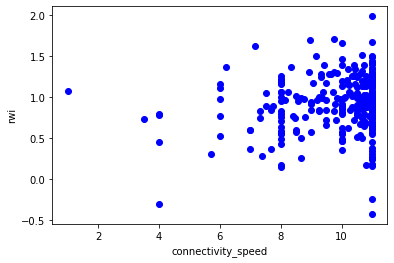

In [32]:
plt.plot(df_u['connectivity_speed'], df_u['rwi'], 'bo') 
plt.ylabel("rwi")
plt.xlabel("connectivity_speed")
plt.savefig('Graph.pdf') 
plt.show() 

In [33]:
list_hex_res = []

for i in range(0, len(df3)):
    h = h3.h3_to_geo_boundary(df3['hex7'][i], True)
    list_hex_res.append(Polygon(h))

df3['geometry'] = list_hex_res

gdf = gpd.GeoDataFrame(df3, crs='EPSG:4326')
gdf = gdf[['hex7','school_count_all','connectivity_speed','population_2020','rwi','error','rur','geometry']]

In [34]:
print(len(gdf))
gdf_r = gdf.loc[df3['rur'] == 'rural']
print(len(gdf_r))
gdf_u = gdf.loc[df3['rur'] == 'urban']
print(len(gdf_u))

4382
4101
281


In [35]:
gdf_u.head()

,hex7,school_count_all,connectivity_speed,population_2020,rwi,error,rur,geometry
183,87109c70dffffff,8,10.625,9396.638563,1.00000,0.3430,urban,"POLYGON ((51.35812 51.18634, 51.37208 51.17644..."
188,87109c741ffffff,2,11.000,1617.449995,0.25100,0.3190,urban,"POLYGON ((51.49311 51.26545, 51.50708 51.25553..."
189,87109c744ffffff,3,8.000,14474.110337,1.17700,0.3665,urban,"POLYGON ((51.43160 51.25659, 51.44557 51.24668..."
190,87109c746ffffff,4,10.750,10720.068174,1.02625,0.3580,urban,"POLYGON ((51.43905 51.23382, 51.45302 51.22391..."
196,87109c766ffffff,1,11.000,7943.460952,0.68150,0.3470,urban,"POLYGON ((51.36264 51.27047, 51.37663 51.26057..."


In [41]:
gdf.to_file('./data/output/kazakhstan_analysis.geojson', driver='GeoJSON')
gdf_r.to_file('./data/output/kazakhstan_analysis_rural.geojson', driver='GeoJSON')
gdf_u.to_file('./data/output/kazakhstan_analysis_urban.geojson', driver='GeoJSON')
